# RSAtoolbox
* get clone from https://github.com/rsagroup/rsatoolbox
  - folked version: https://github.com/eyshin05/rsatoolbox
  
* run a MATLAB function through matlab engine for Python

### Description
* Our dataset is LSS beta values (processed by afni `3dLSS`)
* I'll perform the data ROI-based multivariate connectivity analysis with Linear Discriminant Contrast (LDC)
  - LDC <- That's why I use this toolbox 
* According to the comment of toolbox, if you perform prewhitening your dataset before run the function, it'll be crossnovis distance
  - = cross-validated mahalanobis distance

### Goal
* Get the distances
* Make connectivity matrix

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import glob
import matlab.engine
import matplotlib.pyplot as plt
import nilearn.image
import numpy as np
import pandas as pd
import scipy.io, scipy.stats, scipy.spatial.distance
import seaborn as sns

/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/eyshin/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [17]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# start matlab engine

eng = matlab.engine.start_matlab()

toolboxRoot = '/Users/eyshin/Documents/MATLAB/rsatoolbox-develop'
eng.addpath(eng.genpath(toolboxRoot));

In [3]:
# initialize directory path

data_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02_MO_short_duration/data/'

In [4]:
# initialize ROIs (we use AAL2)

roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/AALnew/'

roi_path = sorted(glob.glob(roi_dir + 'AALnew_ROI_resam*.nii'))
roi_imgs = []

for path in roi_path:
    roi_imgs.append(nilearn.image.load_img(path))

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [5]:
# our subject list

subj_list = [
    'GA01', 'GA02', 'GA05', 'GA07', 'GA08', 'GA11', 'GA12', 'GA13', 'GA14', 'GA15',
    'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 'GA26', 'GA27', 'GA28', 'GA29', 'GA30',
    'GA31', 'GA32', 'GA33', 'GA34', 'GA35', 'GA36', 'GA37', 'GA38', 'GA42', 'GA44',
    'GB01', 'GB02', 'GB05', 'GB07', 'GB08', 'GB11', 'GB12', 'GB13', 'GB14', 'GB15',
    'GB18', 'GB19', 'GB20', 'GB21', 'GB23', 'GB26', 'GB27', 'GB28', 'GB29', 'GB30',
    'GB31', 'GB32', 'GB33', 'GB34', 'GB35', 'GB36', 'GB37', 'GB38', 'GB42', 'GB44'
]

In [6]:
# data loading

data = {}

for subj in subj_list:
    for run in range(1, 7):
        data[subj, run] = nilearn.image.load_img(data_dir + 'betasLSS.MO.shortdur.%s.r%02d.nii.gz' % (subj, run))
    print(subj, end='\r')

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [7]:
# we don't use a first trial of each runs

for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [8]:
# loading target - same in each runs

cond_map = {1:1, 5:2, 21:3, 25:4}
target_pos = []

with open('/Volumes/clmnlab/GA/MVPA/LSS_pb02/behaviors/targetID.txt') as file:
    for line in file:
        target_pos.append(cond_map[int(line.strip())])
        
target_pos = target_pos[1:97]

In [9]:
# you can use nilearn.masking.apply_mask instead, but I think that function is slow a little...

def fast_masking(img, roi):
    img_data = img.get_data()
    roi_mask = roi.get_data().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [10]:
# this functions is where to use the matlab engine instance - 1) save vectors in matlab workspace and 2) run function

def get_crossnobis_distance(X, target):
    B = np.concatenate(X)
    partition = [a+1 for a, x in enumerate(X) for i in range(len(x))]
    conditionVec = target_pos + target_pos + target_pos

    eng.workspace['B'] = matlab.double(B.tolist())
    eng.workspace['partition'] = matlab.double(partition)
    eng.workspace['conditionVec'] = matlab.double(conditionVec)

    (d, Sig) = eng.eval("rsa.distanceLDC(B, partition', conditionVec')", nargout=2)
    
    return d, Sig

In [11]:
# our experimental design constructed with Practiced Mapping Runs (1, 2, 3) & Unpracticed Mapping Runs (4, 5, 6)

results = {}

for subj in subj_list:
    for roi_index, roi in enumerate(roi_imgs, 1):
        X = [
            fast_masking(roi=roi, img=data[subj, 1]), 
            fast_masking(roi=roi, img=data[subj, 2]), 
            fast_masking(roi=roi, img=data[subj, 3]), 
        ]
        
        results['practiced', subj, roi_index] = get_crossnobis_distance(X, target_pos)
        
        X = [
            fast_masking(roi=roi, img=data[subj, 4]), 
            fast_masking(roi=roi, img=data[subj, 5]), 
            fast_masking(roi=roi, img=data[subj, 6]), 
        ]
        
        results['unpracticed', subj, roi_index] = get_crossnobis_distance(X, target_pos)
        
        print(subj, roi_index, end='\r')

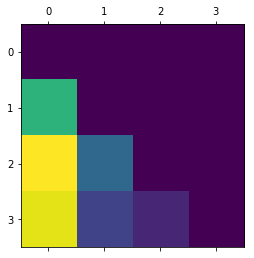

In [12]:
# just visualizing a RDM - averaged RDMs in practiced mapping condition

dist = np.mean([results['practiced', 'GA01', i][0] for i in range(1, 121)], axis=0)[0]
dist_mat = np.zeros((4, 4))
dist_mat[1, 0] = dist[0]
dist_mat[2, 0] = dist[1]
dist_mat[3, 0] = dist[2]
dist_mat[2, 1] = dist[3]
dist_mat[3, 1] = dist[4]
dist_mat[3, 2] = dist[5]
plt.matshow(dist_mat)

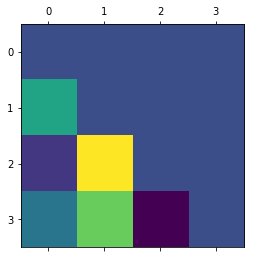

In [13]:
# averaged RDMs in unpracticed mapping condition

dist = np.mean([results['unpracticed', 'GA01', i][0] for i in range(1, 121)], axis=0)[0]
dist_mat = np.zeros((4, 4))
dist_mat[1, 0] = dist[0]
dist_mat[2, 0] = dist[1]
dist_mat[3, 0] = dist[2]
dist_mat[2, 1] = dist[3]
dist_mat[3, 1] = dist[4]
dist_mat[3, 2] = dist[5]
plt.matshow(dist_mat)

In [16]:
# align results

conn_results = []

for i in range(1, 121):
    for j in range(i+1, 121):
        corr = []
        for subj in subj_list:
            conn_results.append({
                'subj': subj,
                'late': 'B' in subj,
                'practiced': True,
                'from_roi': i,
                'to_roi': j,
                'correlation': np.corrcoef(results['practiced', subj, i][0], results['practiced', subj, j][0])[0, 1],
                'cosine': scipy.spatial.distance.cosine(results['practiced', subj, i][0], results['practiced', subj, j][0])
            })
            
            conn_results.append({
                'subj': subj,
                'late': 'B' in subj,
                'practiced': False,
                'from_roi': i,
                'to_roi': j,
                'correlation': np.corrcoef(results['unpracticed', subj, i][0], results['unpracticed', subj, j][0])[0, 1],
                'cosine': scipy.spatial.distance.cosine(results['unpracticed', subj, i][0], results['unpracticed', subj, j][0])
            })
        
conn_df = pd.DataFrame(conn_results)
conn_df.head()

,correlation,cosine,from_roi,late,practiced,subj,to_roi
0,0.953301,0.064232,1,False,True,GA01,2
1,0.924997,0.070643,1,False,False,GA01,2
2,0.945176,0.041918,1,False,True,GA02,2
3,0.187664,0.789710,1,False,False,GA02,2
4,0.946997,0.059891,1,False,True,GA05,2


In [20]:
# helper function for calc mean measure

def mean_score(from_roi, to_roi, practiced, late, measure):
    from_roi, to_roi = sorted((from_roi, to_roi))
    
    sub_df = conn_df[(conn_df['from_roi'] == from_roi) & (conn_df['to_roi'] == to_roi) & 
                     (conn_df['practiced'] == practiced) & (conn_df['late'] == late)]
    
    return sub_df[measure].mean()

In [19]:
# name of regions

aal_names = {
    1: 'Precentral_L', 2: 'Precentral_R', 3: 'Frontal_Sup_2_L', 4: 'Frontal_Sup_2_R', 
    5: 'Frontal_Mid_2_L', 6: 'Frontal_Mid_2_R', 7: 'Frontal_Inf_Oper_L', 8: 'Frontal_Inf_Oper_R', 
    9: 'Frontal_Inf_Tri_L', 10: 'Frontal_Inf_Tri_R', 11: 'Frontal_Inf_Orb_2_L', 12: 'Frontal_Inf_Orb_2_R',
    13: 'Rolandic_Oper_L', 14: 'Rolandic_Oper_R', 15: 'Supp_Motor_Area_L', 16: 'Supp_Motor_Area_R',
    17: 'Olfactory_L', 18: 'Olfactory_R', 19: 'Frontal_Sup_Medial_L', 20: 'Frontal_Sup_Medial_R',
    21: 'Frontal_Med_Orb_L', 22: 'Frontal_Med_Orb_R', 23: 'Rectus_L', 24: 'Rectus_R', 
    25: 'OFCmed_L', 26: 'OFCmed_R', 27: 'OFCant_L', 28: 'OFCant_R', 29: 'OFCpost_L', 
    30: 'OFCpost_R', 31: 'OFClat_L', 32: 'OFClat_R', 33: 'Insula_L', 34: 'Insula_R', 
    35: 'Cingulate_Ant_L', 36: 'Cingulate_Ant_R', 37: 'Cingulate_Mid_L', 38: 'Cingulate_Mid_R', 
    39: 'Cingulate_Post_L', 40: 'Cingulate_Post_R', 41: 'Hippocampus_L', 42: 'Hippocampus_R', 
    43: 'ParaHippocampal_L', 44: 'ParaHippocampal_R', 45: 'Amygdala_L', 46: 'Amygdala_R',
    47: 'Calcarine_L', 48: 'Calcarine_R', 49: 'Cuneus_L', 50: 'Cuneus_R',
    51: 'Lingual_L', 52: 'Lingual_R', 53: 'Occipital_Sup_L', 54: 'Occipital_Sup_R', 
    55: 'Occipital_Mid_L', 56: 'Occipital_Mid_R', 57: 'Occipital_Inf_L', 58: 'Occipital_Inf_R', 
    59: 'Fusiform_L', 60: 'Fusiform_R', 61: 'Postcentral_L', 62: 'Postcentral_R', 
    63: 'Parietal_Sup_L', 64: 'Parietal_Sup_R', 65: 'Parietal_Inf_L', 66: 'Parietal_Inf_R', 
    67: 'SupraMarginal_L', 68: 'SupraMarginal_R', 69: 'Angular_L', 70: 'Angular_R', 
    71: 'Precuneus_L', 72: 'Precuneus_R', 73: 'Paracentral_Lobule_L', 74: 'Paracentral_Lobule_R', 
    75: 'Caudate_L', 76: 'Caudate_R', 77: 'Putamen_L', 78: 'Putamen_R', 
    79: 'Pallidum_L', 80: 'Pallidum_R', 81: 'Thalamus_L', 82: 'Thalamus_R', 
    83: 'Heschl_L', 84: 'Heschl_R', 85: 'Temporal_Sup_L', 86: 'Temporal_Sup_R', 
    87: 'Temporal_Pole_Sup_L', 88: 'Temporal_Pole_Sup_R', 89: 'Temporal_Mid_L',
    90: 'Temporal_Mid_R', 91: 'Temporal_Pole_Mid_L', 92: 'Temporal_Pole_Mid_R', 
    93: 'Temporal_Inf_L', 94: 'Temporal_Inf_R', 95: 'Cerebelum_Crus1_L', 96: 'Cerebelum_Crus1_R',
    97: 'Cerebelum_Crus2_L', 98: 'Cerebelum_Crus2_R', 99: 'Cerebelum_3_L', 100: 'Cerebelum_3_R',
    101: 'Cerebelum_4_5_L', 102: 'Cerebelum_4_5_R', 103: 'Cerebelum_6_L', 104: 'Cerebelum_6_R',
    105: 'Cerebelum_7b_L', 106: 'Cerebelum_7b_R', 107: 'Cerebelum_8_L', 108: 'Cerebelum_8_R', 
    109: 'Cerebelum_9_L', 110: 'Cerebelum_9_R', 111: 'Cerebelum_10_L', 112: 'Cerebelum_10_R', 
    113: 'Vermis_1_2', 114: 'Vermis_3', 115: 'Vermis_4_5', 116: 'Vermis_6', 
    117: 'Vermis_7', 118: 'Vermis_8', 119: 'Vermis_9', 120: 'Vermis_10'
}

In [31]:
# AAL2 modules ordering for visualization

motor = [1, 2, 15, 16, 61, 62]
visual = [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
visuomotor = [63, 64, 65, 66]
basal = [75, 76, 77, 78, 81, 82]
hippo = [41, 42, 43, 44]
cerebellum = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 
                   109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]

roi_order = motor + visual + visuomotor + basal + hippo + cerebellum

roi_modules = [(motor, 'Motor'), 
               (visual, 'Visual'), 
               (visuomotor, 'Visuomotor'),
               (basal, 'Basal Ganglia'), 
               (hippo, 'Hippocampus'), 
               (cerebellum, 'Cerebellum')]

In [32]:
# xticks respresents modules information

xticks = [-0.5]

for xtick in [len(motor), len(visual), len(visuomotor), len(basal), len(hippo), len(cerebellum)]:
    xticks.append(xticks[-1] + xtick)
    
xticks

[-0.5, 5.5, 19.5, 23.5, 29.5, 33.5, 59.5]

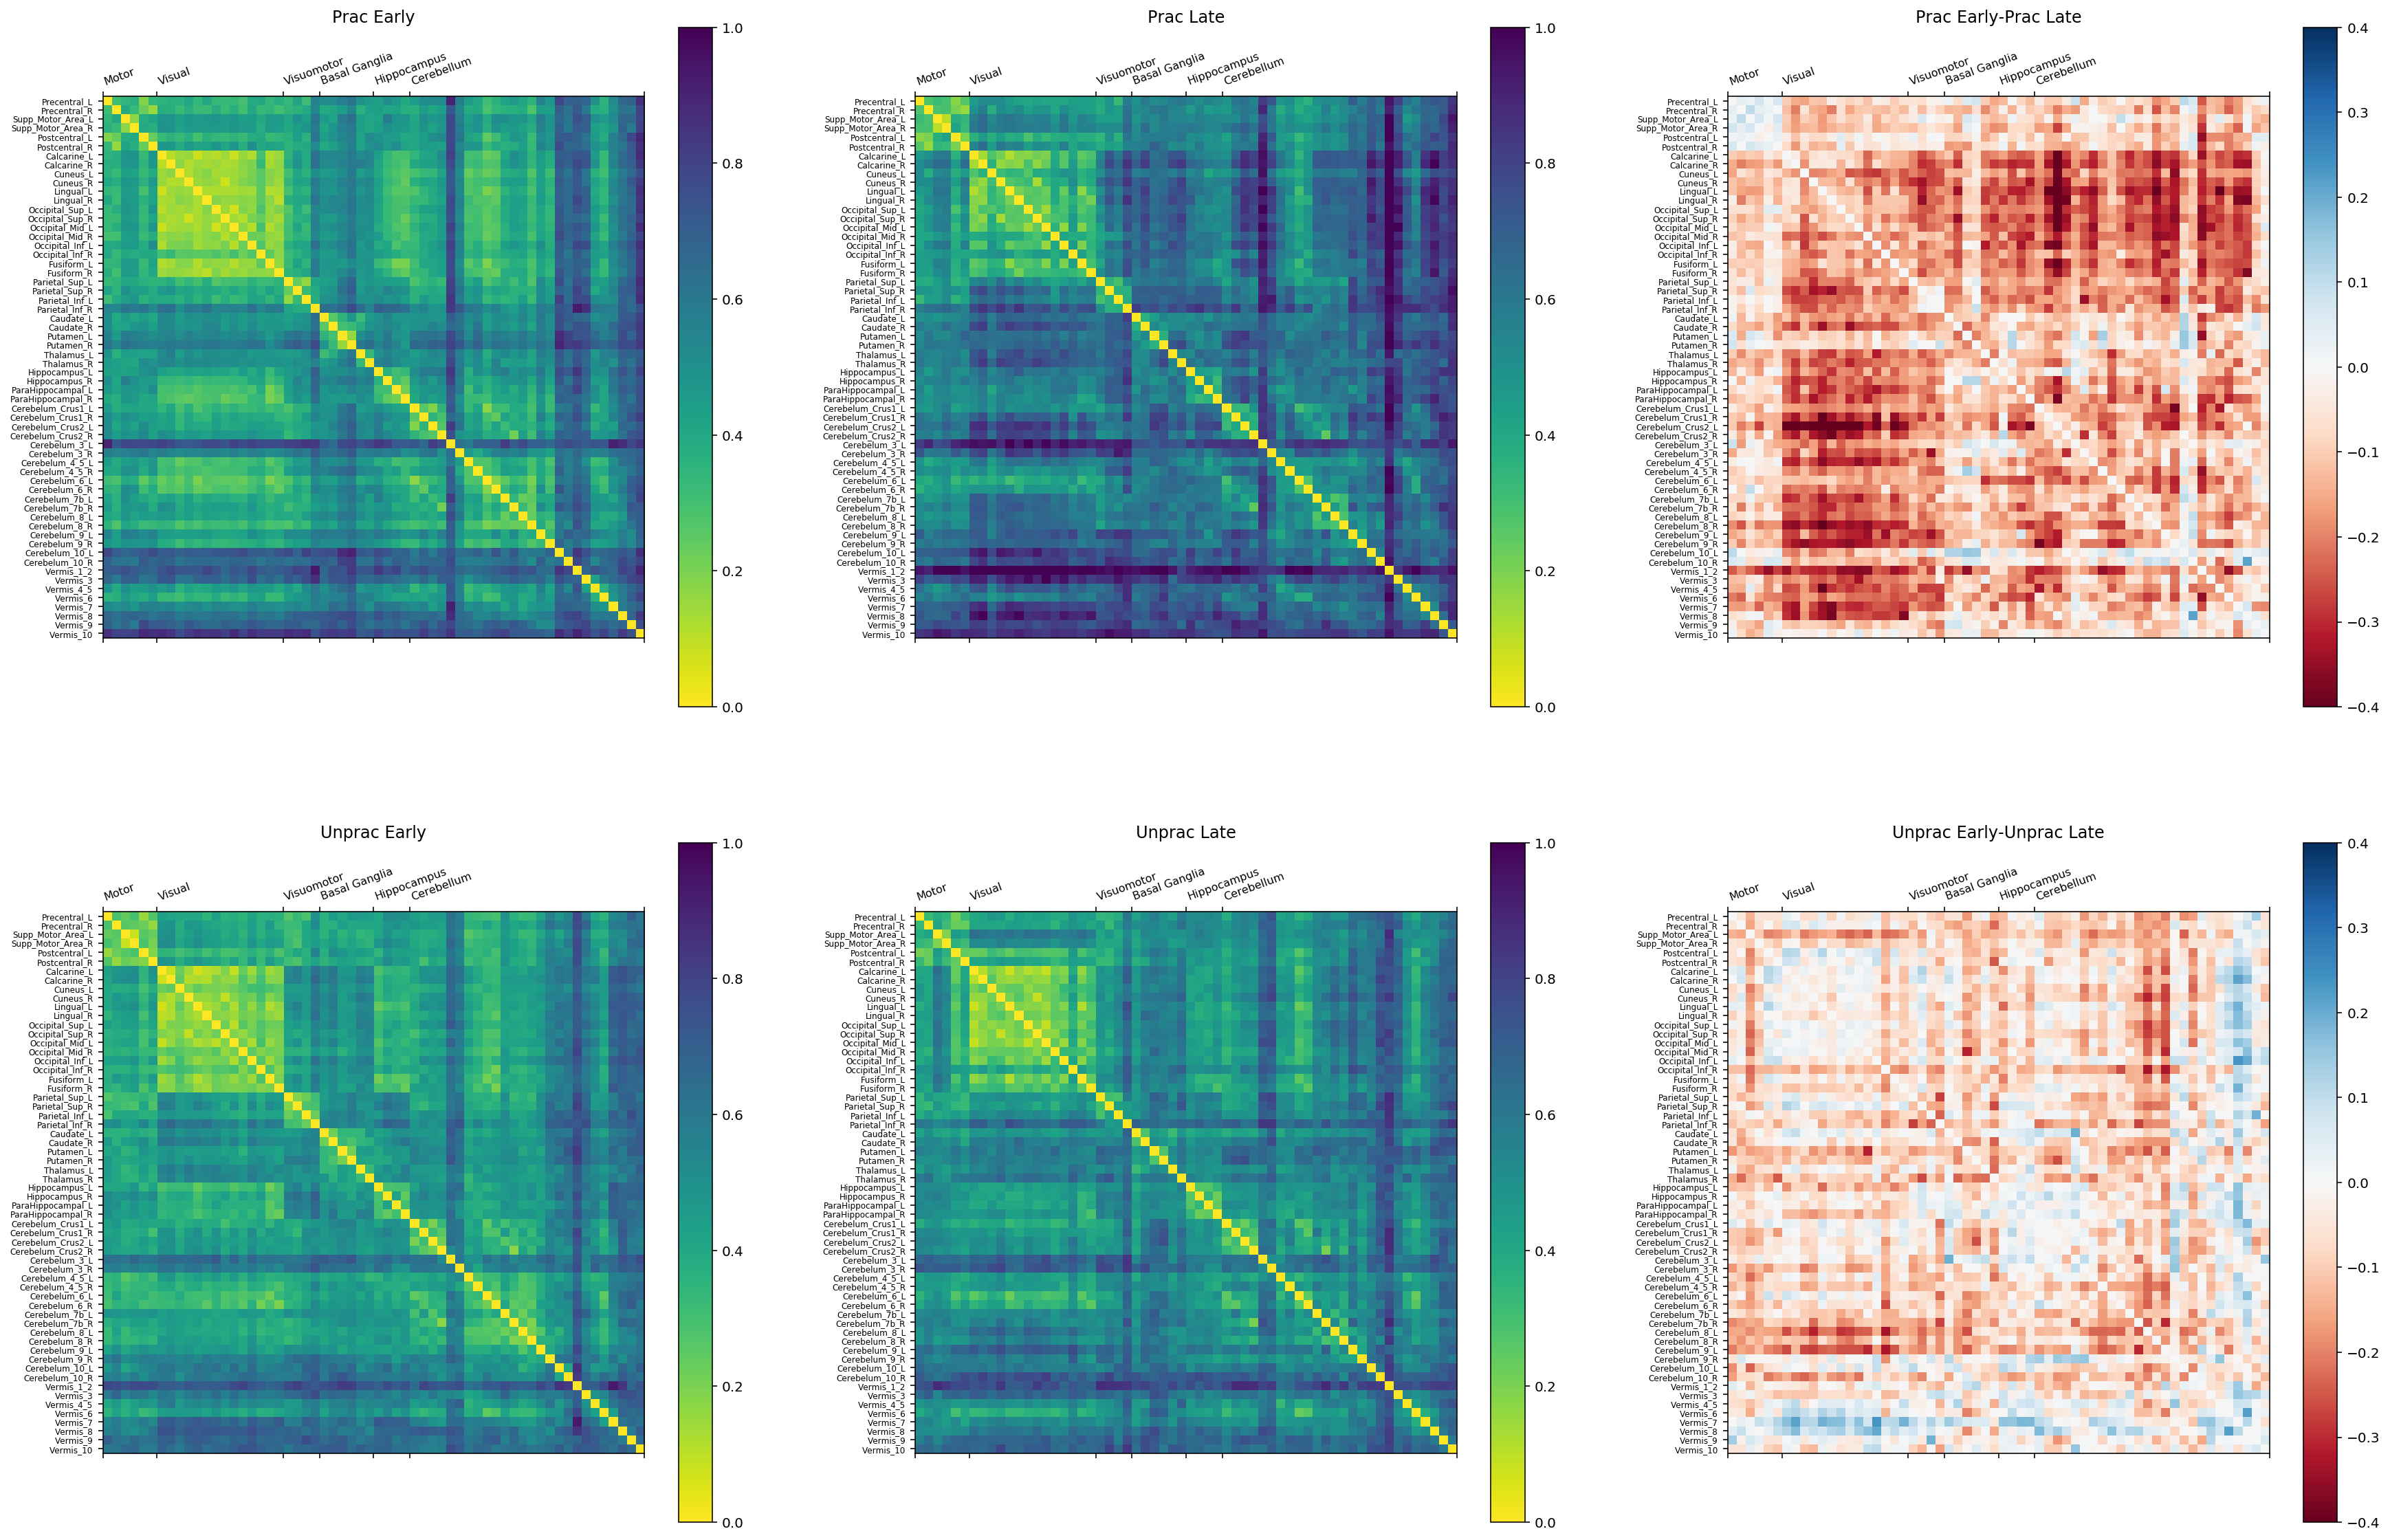

In [33]:
# visualization (cosine similarity)

p_early_conn_mat = np.zeros((len(roi_order), len(roi_order)))

for i, from_roi in enumerate(roi_order):
    for j, to_roi in enumerate(roi_order[i+1:]):
        
        score = mean_score(from_roi, to_roi, True, False, 'cosine')
        
        p_early_conn_mat[i, i+j+1] = score
        p_early_conn_mat[i+j+1, i] = score
        
p_late_conn_mat = np.zeros((len(roi_order), len(roi_order)))

for i, from_roi in enumerate(roi_order):
    for j, to_roi in enumerate(roi_order[i+1:]):
        
        score = mean_score(from_roi, to_roi, True, True, 'cosine')
        
        p_late_conn_mat[i, i+j+1] = score
        p_late_conn_mat[i+j+1, i] = score
        
diff_conn_mat = p_early_conn_mat - p_late_conn_mat

plt.figure(figsize=(30,20))

ax = plt.subplot(2, 3, 1)
plt.matshow(p_early_conn_mat, fignum=False, vmax=1.0, cmap='viridis_r')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Prac Early\n\n')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.matshow(p_late_conn_mat, fignum=False, vmax=1.0, cmap='viridis_r')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Prac Late\n\n')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.matshow(diff_conn_mat, fignum=False, vmin=-0.4, vmax=0.4, cmap='RdBu')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Prac Early-Prac Late\n\n')
plt.colorbar()

up_early_conn_mat = np.zeros((len(roi_order), len(roi_order)))

for i, from_roi in enumerate(roi_order):
    for j, to_roi in enumerate(roi_order[i+1:]):
        
        score = mean_score(from_roi, to_roi, False, False, 'cosine')
        
        up_early_conn_mat[i, i+j+1] = score
        up_early_conn_mat[i+j+1, i] = score
        
up_late_conn_mat = np.zeros((len(roi_order), len(roi_order)))

for i, from_roi in enumerate(roi_order):
    for j, to_roi in enumerate(roi_order[i+1:]):
        
        score = mean_score(from_roi, to_roi, False, True, 'cosine')
        
        up_late_conn_mat[i, i+j+1] = score
        up_late_conn_mat[i+j+1, i] = score
        
diff_conn_mat = up_early_conn_mat - up_late_conn_mat

ax = plt.subplot(2, 3, 4)
plt.matshow(up_early_conn_mat, fignum=False, vmax=1.0, cmap='viridis_r')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Unprac Early\n\n')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.matshow(up_late_conn_mat, fignum=False, vmax=1.0, cmap='viridis_r')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Unprac Late\n\n')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.matshow(diff_conn_mat, fignum=False, vmin=-0.4, vmax=0.4, cmap='RdBu')
plt.xticks(xticks, [b for _, b in roi_modules], rotation=20, ha='left', fontsize=8)
plt.yticks(np.arange(0, len(roi_order)), [aal_names[i] for i in roi_order], fontsize=6)
plt.title('Unprac Early-Unprac Late\n\n')
plt.colorbar()

plt.show()